In [11]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from io import BytesIO
from PIL import Image

In [12]:
# =========================
# 1. Scrape & Save Image
# =========================
headers = {'User-Agent': 'Mozilla/5.0'}
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b3/Carettochelys_insculpta.jpg/200px-Carettochelys_insculpta.jpg"

r = requests.get(url, headers=headers)
img = Image.open(BytesIO(r.content))
file_ext = ".png" if img.format == "PNG" else ".jpg"
filename = "Carettochelyidae_turtle" + file_ext
img.save(filename)
print(f"Image saved as {filename}")

Image saved as Carettochelyidae_turtle.jpg


In [13]:
# Convert to OpenCV (numpy array)
image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

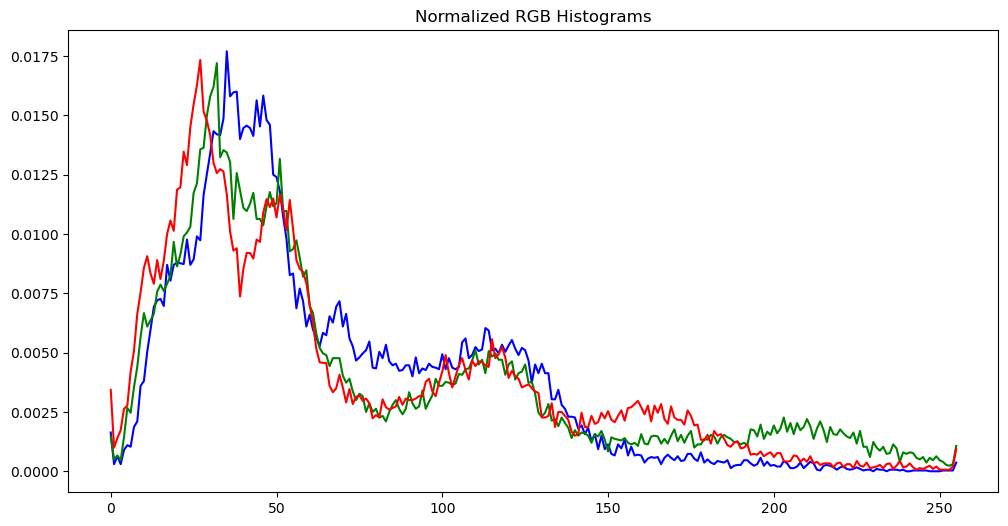

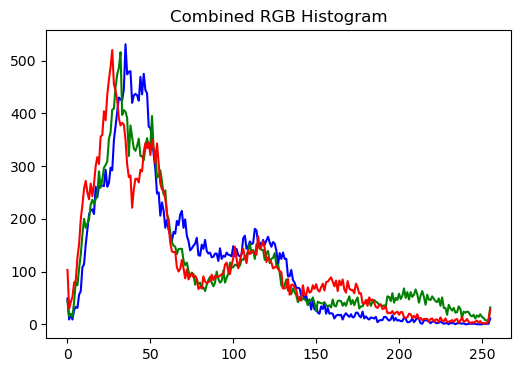

In [14]:
# =========================
# 2. Histogram Analysis
# =========================
colors = ('b','g','r')
plt.figure(figsize=(12,6))
for i,col in enumerate(colors):
    hist = cv2.calcHist([image],[i],None,[256],[0,256])
    hist = hist / hist.sum()   # normalize
    plt.plot(hist,color=col)
plt.title("Normalized RGB Histograms")
plt.show()

# Combined histogram
plt.figure(figsize=(6,4))
for i,col in enumerate(colors):
    plt.plot(cv2.calcHist([image],[i],None,[256],[0,256]), color=col)
plt.title("Combined RGB Histogram")
plt.show()


In [15]:
# =========================
# 3. Intensity Transformations
# =========================
# Convert to float for log/gamma
img_float = image.astype(np.float32)/255.0

# Log transformation
c = 1 / np.log(1 + np.max(img_float))
log_img = c * (np.log(1 + img_float))
log_img = np.uint8(255 * log_img)

# Gamma correction
gamma1 = 0.5
gamma2 = 2.0
gamma_img1 = np.uint8(255 * np.power(img_float, gamma1))
gamma_img2 = np.uint8(255 * np.power(img_float, gamma2))

# Contrast stretching
min_val, max_val = 50, 200
contrast_img = np.clip((image - min_val) * (255.0/(max_val-min_val)), 0, 255).astype(np.uint8)


In [16]:
# =========================
# 4. Histogram Equalization
# =========================
# Equalize each RGB channel
channels = cv2.split(image)
eq_rgb = [cv2.equalizeHist(ch) for ch in channels]
eq_rgb = cv2.merge(eq_rgb)

# Equalize luminance in YCrCb
img_ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
y,cr,cb = cv2.split(img_ycrcb)
y_eq = cv2.equalizeHist(y)
eq_ycrcb = cv2.merge([y_eq,cr,cb])
eq_luminance = cv2.cvtColor(eq_ycrcb, cv2.COLOR_YCrCb2BGR)


In [17]:
# =========================
# 5. Thresholding & Segmentation
# =========================
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Otsu
_, otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Adaptive
adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 11, 2)

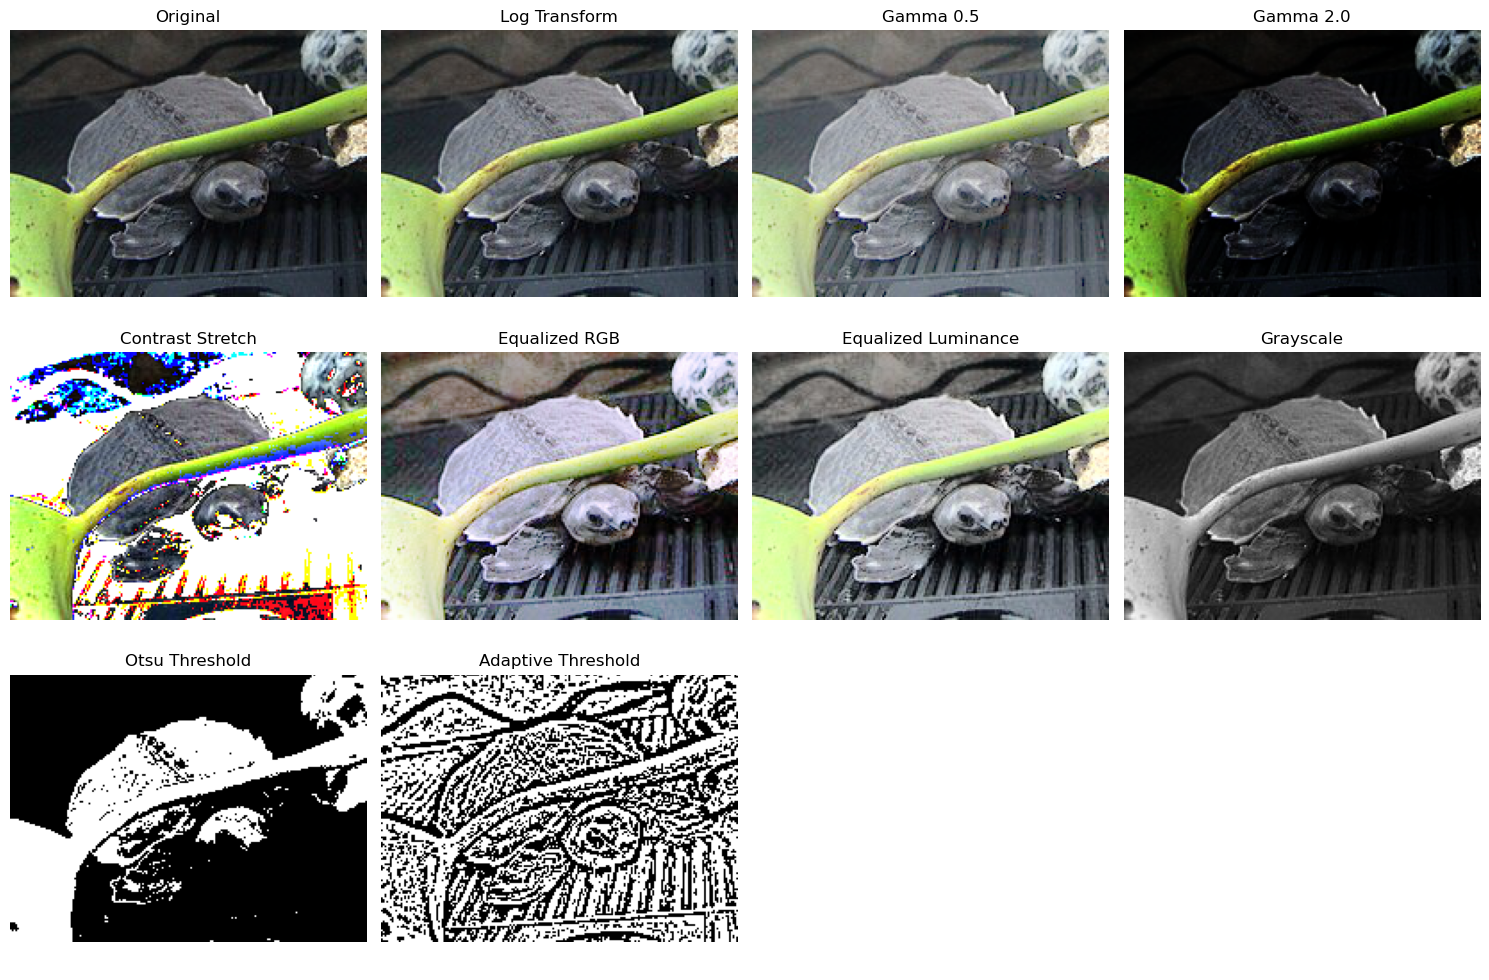

In [18]:
# =========================
# 6. Visualization Layout
# =========================
fig, axs = plt.subplots(3,4, figsize=(15,10))
axs[0,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); axs[0,0].set_title("Original"); axs[0,0].axis('off')
axs[0,1].imshow(cv2.cvtColor(log_img, cv2.COLOR_BGR2RGB)); axs[0,1].set_title("Log Transform"); axs[0,1].axis('off')
axs[0,2].imshow(cv2.cvtColor(gamma_img1, cv2.COLOR_BGR2RGB)); axs[0,2].set_title("Gamma 0.5"); axs[0,2].axis('off')
axs[0,3].imshow(cv2.cvtColor(gamma_img2, cv2.COLOR_BGR2RGB)); axs[0,3].set_title("Gamma 2.0"); axs[0,3].axis('off')

axs[1,0].imshow(cv2.cvtColor(contrast_img, cv2.COLOR_BGR2RGB)); axs[1,0].set_title("Contrast Stretch"); axs[1,0].axis('off')
axs[1,1].imshow(cv2.cvtColor(eq_rgb, cv2.COLOR_BGR2RGB)); axs[1,1].set_title("Equalized RGB"); axs[1,1].axis('off')
axs[1,2].imshow(cv2.cvtColor(eq_luminance, cv2.COLOR_BGR2RGB)); axs[1,2].set_title("Equalized Luminance"); axs[1,2].axis('off')
axs[1,3].imshow(gray, cmap='gray'); axs[1,3].set_title("Grayscale"); axs[1,3].axis('off')

axs[2,0].imshow(otsu, cmap='gray'); axs[2,0].set_title("Otsu Threshold"); axs[2,0].axis('off')
axs[2,1].imshow(adaptive, cmap='gray'); axs[2,1].set_title("Adaptive Threshold"); axs[2,1].axis('off')
axs[2,2].axis('off')
axs[2,3].axis('off')

plt.tight_layout()
plt.show()

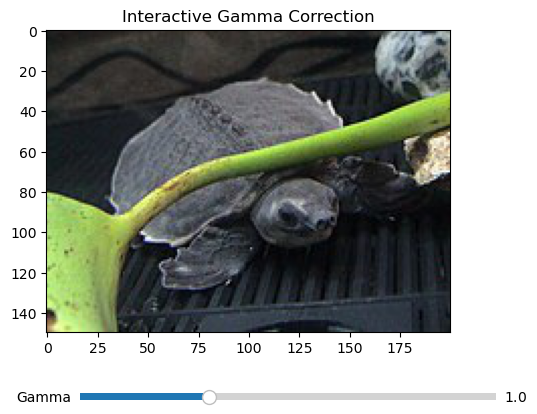

In [19]:
# =========================
# 7. Interactive Gamma Slider
# =========================
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)

ax_img = plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax.set_title("Interactive Gamma Correction")

ax_slider = plt.axes([0.25, 0.1, 0.65, 0.03])
gamma_slider = Slider(ax_slider, 'Gamma', 0.1, 3.0, valinit=1.0)

def update(val):
    gamma = gamma_slider.val
    corrected = np.uint8(255 * np.power(img_float, gamma))
    ax_img.set_data(cv2.cvtColor(corrected, cv2.COLOR_BGR2RGB))
    fig.canvas.draw_idle()

gamma_slider.on_changed(update)
plt.show()
